Import Libraries

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import timedelta as td
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#from pandas_datareader import data as pdr

Declare the Date Range for Our Stock Returns

In [2]:
#set today as endDate
endDate = dt.datetime.now()

#let the startDate be 5 years ago
startDate = endDate - dt.timedelta(days = 365 * 5)
endDate, startDate

(datetime.datetime(2024, 12, 28, 22, 18, 44, 981967),
 datetime.datetime(2019, 12, 30, 22, 18, 44, 981967))

Create a Lists of Stocks (Tickers)

In [3]:
tickers = ['NVDA', 'WMT', 'MSFT', 'GOOGL']

Download stock data from yfinance

In [4]:
tickers = ['NVDA', 'WMT', 'MSFT', 'GOOGL']
close_price = pd.DataFrame()
for ticker in tickers:
    df = yf.download(ticker, start = startDate, end = endDate)
    close_price[ticker] = df['Close']
close_price.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,NVDA,WMT,MSFT,GOOGL
Date,,,,
2019-12-31,5.857941,36.751663,151.139664,66.727600
2020-01-02,5.972710,36.782578,153.938187,68.186821
2020-01-03,5.877111,36.457863,152.021423,67.830101
2020-01-06,5.901758,36.383640,152.414307,69.638054
2020-01-07,5.973209,36.046551,151.024643,69.503548


In [5]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2019-12-31,66.727600,66.790870,66.365912,66.548250,19514000
2020-01-02,68.186821,68.186821,67.081331,67.176985,27278000
2020-01-03,67.830101,68.439396,67.122666,67.156548,23408000
2020-01-06,69.638054,69.663459,67.306008,67.337388,46768000
2020-01-07,69.503548,69.921535,69.326691,69.770083,34330000


Calculate Daily Log Returns

In [6]:
log_returns = np.log(close_price/close_price.shift(1))
log_returns.tail()

,NVDA,WMT,MSFT,GOOGL
Date,,,,
2024-12-20,0.030299,-0.012498,-0.000984,0.015267
2024-12-23,0.036232,-0.020703,-0.003097,0.016683
2024-12-24,0.003930,0.025462,0.009330,0.007575
2024-12-26,-0.002070,0.001186,-0.002781,-0.002604
2024-12-27,-0.021088,-0.012253,-0.017453,-0.014626


Calculate cummulative returns

In [7]:
cumulative_returns = log_returns.cumsum()
cumulative_returns.head()

,NVDA,WMT,MSFT,GOOGL
Date,,,,
2019-12-31,NaN,NaN,NaN,NaN
2020-01-02,0.019403,0.000841,0.018347,0.021633
2020-01-03,0.003267,-0.008026,0.005817,0.016387
2020-01-06,0.007452,-0.010064,0.008398,0.042693
2020-01-07,0.019486,-0.019372,-0.000761,0.040759


<Axes: title={'center': 'Cumulative Returns'}, xlabel='Date'>

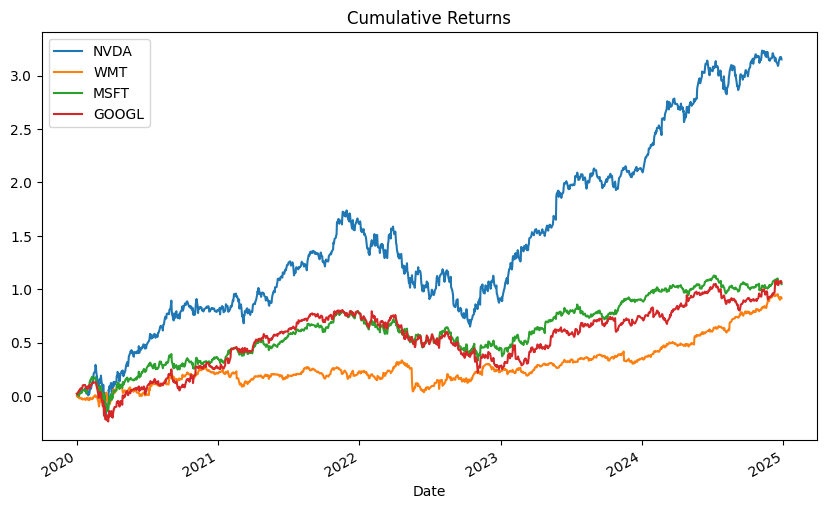

In [8]:
cumulative_returns.plot(title="Cumulative Returns", figsize=(10, 6))

Calculate Covariance Matrix (Annualized by Multiplying with 252 Trading Days)

In [9]:
cov_matrix = log_returns.cov() * 252
cov_matrix

,NVDA,WMT,MSFT,GOOGL
NVDA,0.286554,0.029822,0.112552,0.104651
WMT,0.029822,0.050989,0.025962,0.021611
MSFT,0.112552,0.025962,0.093253,0.074357
GOOGL,0.104651,0.021611,0.074357,0.105911


Define Portfolio Performance Metrics

In [10]:
#Calculate the Annualized Return Expected
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

#Calculate the Volatility
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

#Calculate the Risk-Adjusted Return (Sharpe Ratio)
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

Portfilio Optimization

In [11]:


risk_free_rate = 0.025

#Negate sharpe ratio enable the use of optimization algorithms that are designed to minimize a function.
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#Set constraints to ensure the sum of the weights adds upto 1

constraints = {'type' : "eq", 'fun': lambda weights: np.sum(weights) - 1}

#Set bounds to ensure the weight of each assets are within 0 and 1
bounds = [(0, 0.3) for _ in range(len(tickers))]

#Create a list of equal weights for all assets
initial_weights = np.array([1/len(tickers)]*len(tickers))

# Optimize for maximum Sharpe ratio
optimized_results = minimize(neg_sharpe_ratio, 
                          initial_weights, 
                          args=(log_returns, cov_matrix, risk_free_rate), 
                          method='SLSQP', 
                          constraints=constraints, 
                          bounds=bounds)

print("Optimal Portfolio Weights:", optimized_results.x) 

Optimal Portfolio Weights: [0.3        0.3        0.16239949 0.23760051]


Optimal Portfolio Analysis

In [12]:
#optimized_results.x is optimal weight
for ticker, weight in zip(tickers, optimized_results.x):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimized_results.x, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_results.x, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_results.x, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

NVDA: 0.3000
WMT: 0.3000
MSFT: 0.1624
GOOGL: 0.2376
Expected Annual Return: 0.3294
Expected Volatility: 0.2853
Sharpe Ratio: 1.0669


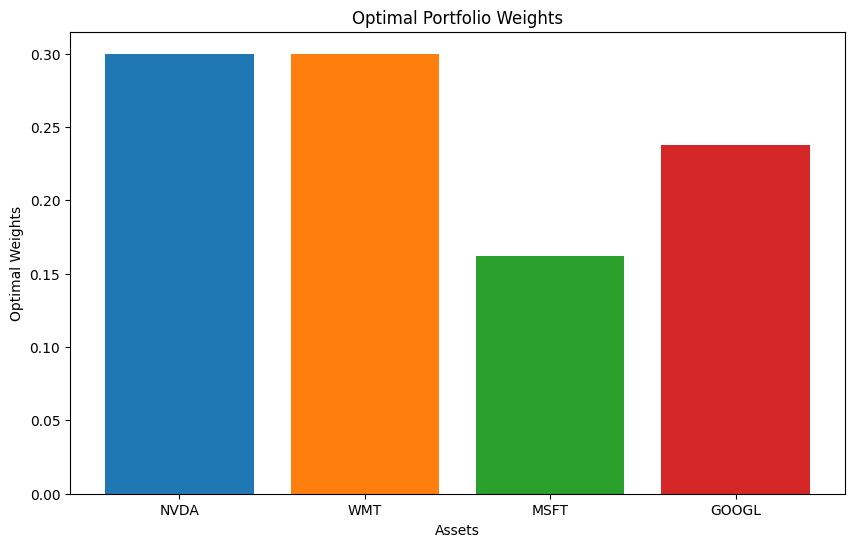

In [13]:
#Assign optimal_weights variable 
optimal_weights = optimized_results.x

#Choose a colormap
cmap = plt.cm.tab10 

#Create an array of colors based on the chosen colormap
colors = cmap(np.arange(len(tickers)) % cmap.N)

#Ploting a bar graph to visualize the portfolio weights
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights, color=colors)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

Monte Carlo Price Simulation

In [14]:
log_returns = log_returns.dropna()

# Calculate mean and covariance matrix of daily log returns
return_means = log_returns.mean()
cov_matrix = log_returns.cov()

#Define simulation parameters
num_simulations = 1000
simulation_days = 252 # trading days 
num_tickers = len(close_price.columns)
dates = close_price.index

# Generate simulated dates based on the historical dates
simulated_dates = pd.date_range(start=dates[-1], periods=simulation_days, freq='B')  # 'B' for business days

# Generate correlated random returns
daily_returns = np.random.multivariate_normal(return_means, cov_matrix, (num_simulations, simulation_days))

#Initialize array of simulated prices
simulated_prices = np.zeros((num_simulations, simulation_days, num_tickers))

#Set initial price for simulation to be the Last closing price
simulated_prices[:, 0, :] = close_price.iloc[-1].values.reshape(1, 1, num_tickers)

# Simulate prices
for i in range(1, simulation_days):
    simulated_prices[:, i, :] = simulated_prices[:, i - 1, :] * np.exp(daily_returns[:, i - 1, :])
    



Generate Predicted Prices (Simulated Prices)

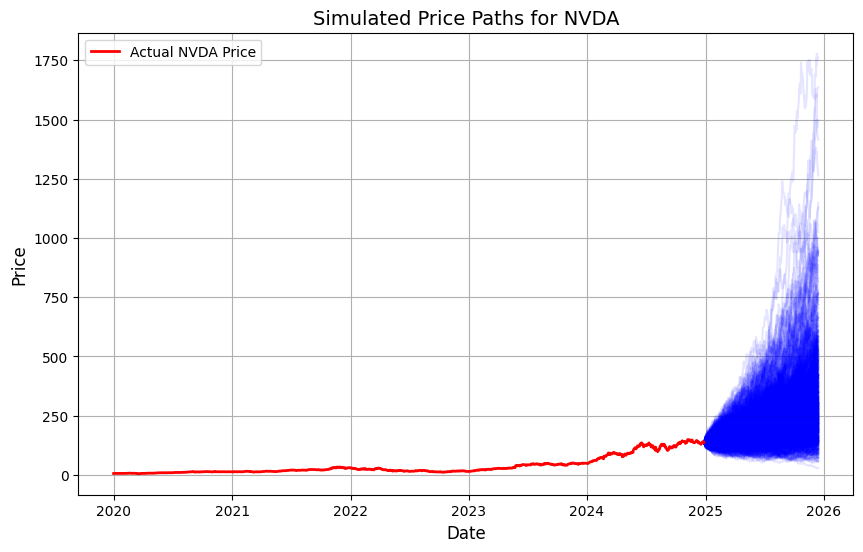

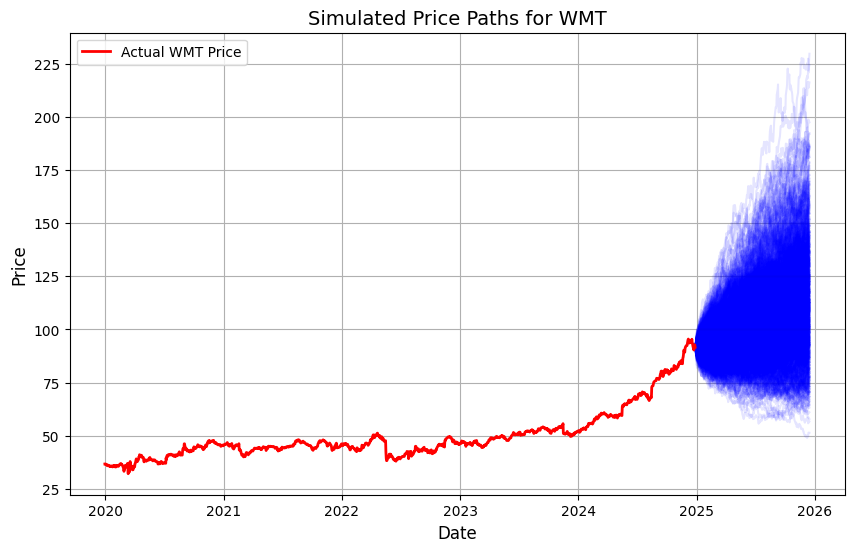

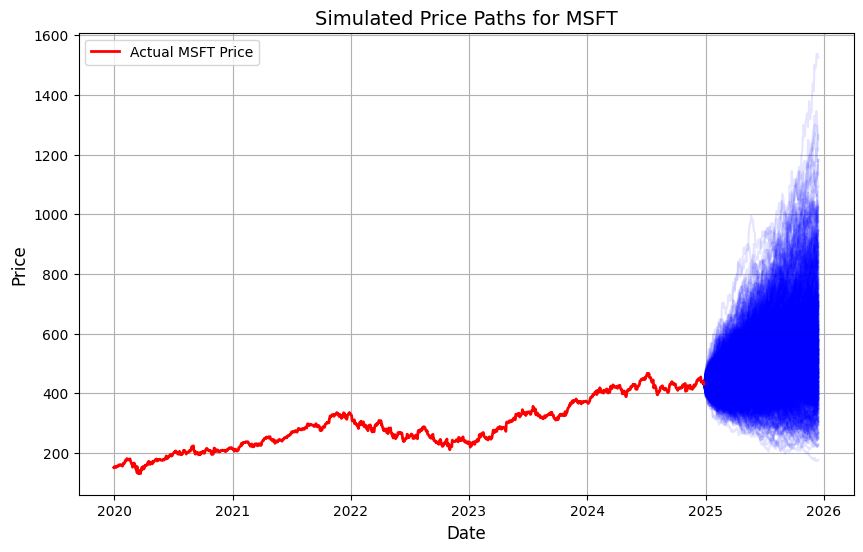

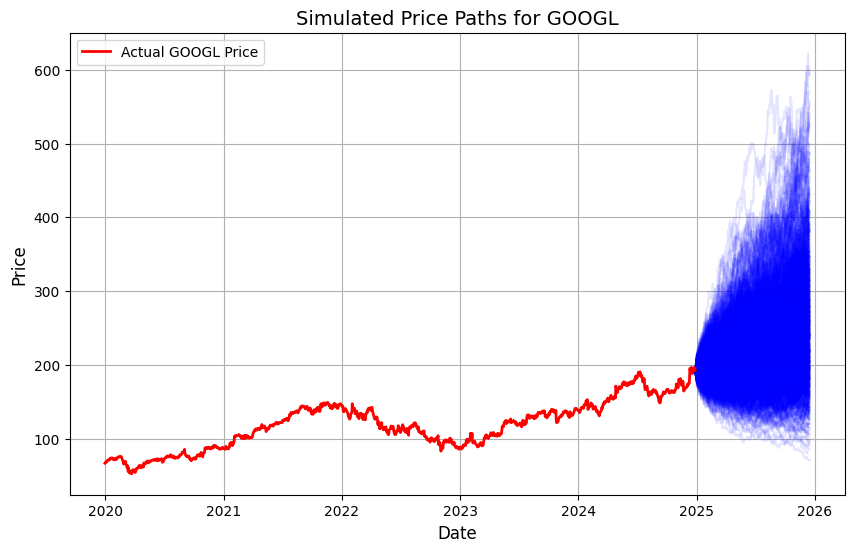

In [15]:

# Plot simulated price paths for each ticker
for ticker_index, ticker in enumerate(close_price.columns):
    plt.figure(figsize=(10, 6))
    
    # Plot the simulated price paths for this ticker
    for simulation in range(num_simulations):
        plt.plot(simulated_dates, simulated_prices[simulation, :, ticker_index], alpha=0.1, color='blue')  # Simulated paths
    
    # Plot the actual price path
    plt.plot(dates, close_price[ticker], label=f"Actual {ticker} Price", color='red', linewidth=2)  # Actual closing price
    
    # Add title and labels
    plt.title(f"Simulated Price Paths for {ticker}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True)
    
    # Show the plot
    plt.show()

Visualization of Simulated Data

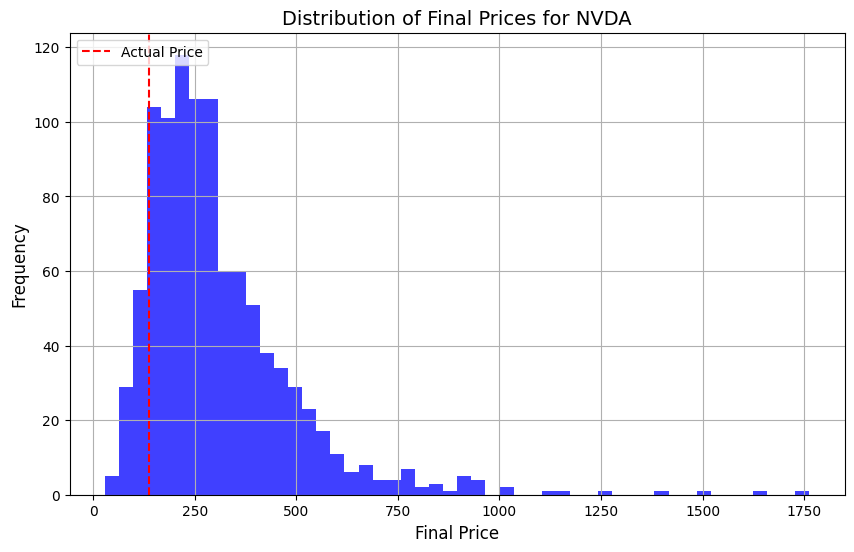

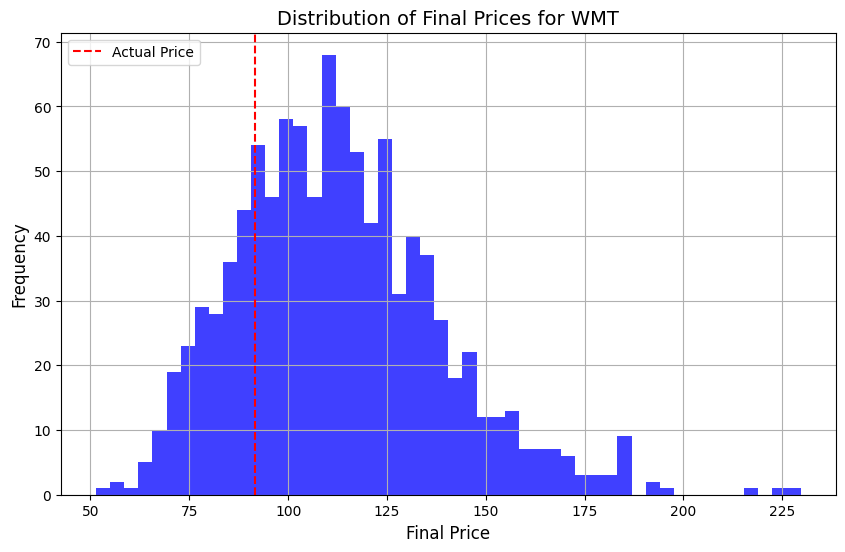

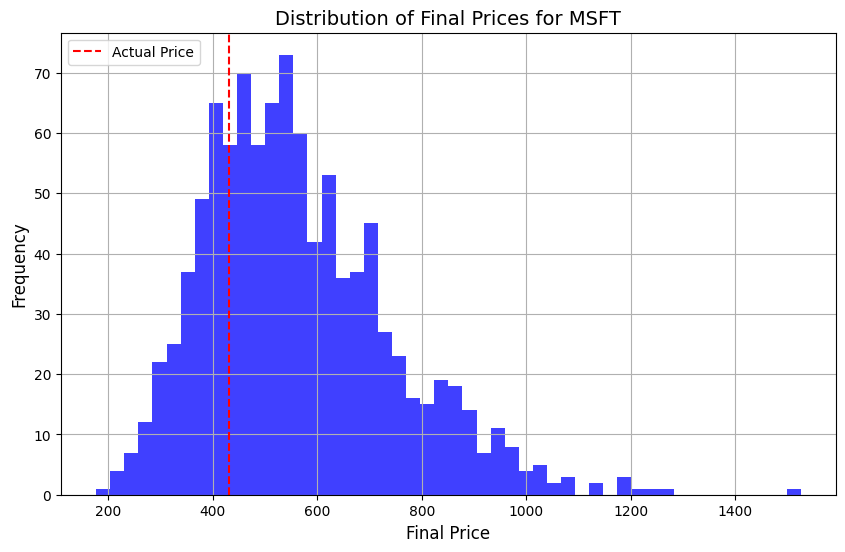

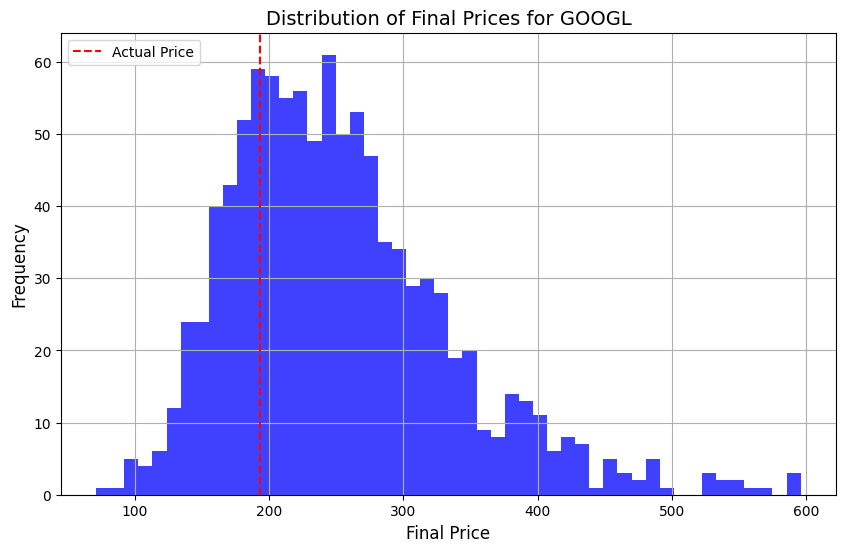

In [16]:
#Plot histograms of the final simulated prices for each ticker 
for ticker_index, ticker in enumerate(close_price.columns):
    final_prices = simulated_prices[:, -1, ticker_index]
    plt.figure(figsize=(10, 6))
    plt.hist(final_prices, bins=50, alpha=0.75, color='blue')
    plt.axvline(x=close_price[ticker].iloc[-1], color='red', linestyle='--', label='Actual Price')
    plt.title(f"Distribution of Final Prices for {ticker}", fontsize=14)
    plt.xlabel("Final Price", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

Statistical Analysis and Summary

In [17]:
final_prices_summary = {}
for ticker_index, ticker in enumerate(close_price.columns):
    final_prices = simulated_prices[:, -1, ticker_index]
    final_prices_summary[ticker] = {
        'mean': round(float(np.mean(final_prices)),2),
        'std_dev': round(float(np.std(final_prices)),2),
        '5th_percentile': round(float(np.percentile(final_prices, 5)),2),
        '50th_percentile': round(float(np.percentile(final_prices, 50)),2),
        '95th_percentile': round(float(np.percentile(final_prices, 95)),2)
    }

# Convert the dictionary into a pandas DataFrame
final_prices_df = pd.DataFrame(final_prices_summary).T

# Display the DataFrame
print(final_prices_df)

         mean  std_dev  5th_percentile  50th_percentile  95th_percentile
NVDA   307.83   186.74          108.40           263.96           628.48
WMT    112.71    25.79           74.87           110.52           158.55
MSFT   564.82   182.32          317.29           536.23           902.77
GOOGL  252.68    82.60          143.34           240.42           406.90


Value at Risk (VaR) and Conditional VaR (CVaR)

In [18]:
# Value at Risk (VaR)
# Measure the potential loss in value of an asset over a defined period for a given confidence interval (95% VaR).
VaR_95 = {}
for ticker_index, ticker in enumerate(close_price.columns):
    final_prices = simulated_prices[:, -1, ticker_index]
    VaR_95[ticker] = {
        'VaR_95' : round(float(np.percentile(final_prices, 5)),2)
    } # 5th percentile (95% confidence level)
    
VaR_95_df = pd.DataFrame(VaR_95).T
VaR_95_df

,VaR_95
NVDA,108.40
WMT,74.87
MSFT,317.29
GOOGL,143.34


Conditional VaR (CVaR)

In [19]:
#This is the average of the losses that exceed the VaR.
#It's useful to understand the magnitude of loss in the worst cases.

CVaR_95 = {}
for ticker_index, ticker in enumerate(close_price.columns):
    final_prices = simulated_prices[:, -1, ticker_index]
    # Get the actual price (last closing price)
    actual_price = close_price[ticker].iloc[-1]
    VaR_95_value = VaR_95[ticker]
    # Calculate losses (final price - actual price) only for prices below VaR
    
    losses = actual_price - final_prices
    # Calculate the Conditional VaR (CVaR) as the average of losses exceeding VaR
    CVaR_95[ticker] = {
        'CVaR_95' : round(np.mean(losses) if len(losses) >= 0 else 0, 2)  # If no losses, set CVaR to 0
        
    }
    
CVaR_95_df = pd.DataFrame(CVaR_95).T
CVaR_95_df


,CVaR_95
NVDA,-170.82
WMT,-21.05
MSFT,-134.29
GOOGL,-59.92


Scenario Analysis

In [20]:
#Best Case, Worst Case, and Base Case

scenario_analysis = {}
for ticker_index, ticker in enumerate(close_price.columns):
    final_prices = simulated_prices[:, -1, ticker_index]
    scenario_analysis[ticker] = {
        'best_case': round(np.max(final_prices),2),
        'base_case': round(np.median(final_prices),2),
        'worst_case': round(np.min(final_prices),2)
            }

scenario_analysis_df = pd.DataFrame(scenario_analysis)
scenario_analysis_df

,NVDA,WMT,MSFT,GOOGL
best_case,1762.87,229.65,1524.72,595.94
base_case,263.96,110.52,536.23,240.42
worst_case,28.83,51.43,176.74,71.04


Sensitivity Analysis